## Implementasi Metode Lama : Active Contour
### Mendapatkan Data

In [16]:
import cv2               as cv
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import os
import time

from skimage.filters import gaussian
from skimage.segmentation import active_contour

DATASET_PATH = 'Wound_dataset/'

def pick(data, number):
    parent = data.capitalize()
    child = data.lower()
    if parent == 'Ingrown_nails':
        child = 'ingrown_nail'
    if parent == 'Laceration':
        child = 'laseration'
    path = DATASET_PATH + parent + '/' + child + ' (' + str(number) + ').jpg'
    if not os.path.exists(path):
        print('File tidak ditemukan')
    return path

citra = cv.imread(pick('cut', 15))

## Pre-processing

### Grayscaling

In [ ]:
citra_grayscale = cv.cvtColor(citra, cv.COLOR_BGR2GRAY)

fig, axes = plt.subplots(1, 2,figsize=(10, 5))
axes[0].imshow(cv.cvtColor(citra, cv.COLOR_BGR2RGB))
axes[0].set_title("Citra Original")
axes[0].axis('off')
axes[1].imshow(citra_grayscale, cmap='gray')
axes[1].set_title("Citra Grayscale")
axes[1].axis('off')
plt.show()

### Pencerahan

In [ ]:
brightness = 200
citra_brightened = cv.add(citra_grayscale, brightness)

fig, axes = plt.subplots(1, 2,figsize=(10, 5))
axes[0].imshow(citra_grayscale, cmap='gray')
axes[0].set_title("Citra Grayscale")
axes[0].axis('off')
axes[1].imshow(citra_brightened, cmap='gray')
axes[1].set_title("Citra Diterangkan")
axes[1].axis('off')
plt.show()

### Denoising Citra

In [ ]:
citra_denoise = cv.medianBlur(citra_brightened, 3)
citra_denoise = cv.fastNlMeansDenoising(citra_denoise, None, 10, 10, 7)

fig, axes = plt.subplots(1, 2,figsize=(10, 5))
axes[0].imshow(citra_brightened, cmap='gray')
axes[0].set_title("Citra Diterangkan")
axes[0].axis('off')
axes[1].imshow(citra_denoise, cmap='gray')
axes[1].set_title("Citra Denoise")
axes[1].axis('off')
plt.show()

### Penyesuaian Kontras

In [ ]:
citra_contrast_adjusted = cv.equalizeHist(citra_denoise)

fig, axes = plt.subplots(1, 2,figsize=(10, 5))
axes[0].imshow(citra_denoise, cmap='gray')
axes[0].set_title("Citra Denoise")
axes[0].axis('off')
axes[1].imshow(citra_contrast_adjusted, cmap='gray')
axes[1].set_title("Citra Contrast Adjustment")
axes[1].axis('off')
plt.show()

### Segmentasi dengan Active Contour

In [ ]:
s = np.linspace(0, 2*np.pi, 500)
r = 300 + 300*np.sin(s)
c = 320 + 300*np.cos(s)
init = np.array([r, c]).T

# Segmentasi dengan Active Contour
snake = active_contour(gaussian(citra_contrast_adjusted, 3, preserve_range=False),
                       init, alpha=0.01, beta=0, gamma=0.001)

fig, axes = plt.subplots(1, 2,figsize=(10, 5))
axes[0].set_title("Citra Original")
axes[0].imshow(citra[...,::-1], cmap='gray')
axes[0].axis('off')
axes[1].imshow(citra[...,::-1], cmap='gray')
axes[1].plot(snake[:, 1], snake[:, 0], '-w', lw=3)
axes[1].set_title("Hasil Segmentasi dengan Active Contour")
axes[1].axis('off')
plt.show()

selisih = np.array(citra_denoise) - np.array(citra[:, :, 0])
mse = np.mean(np.square(selisih))
psnr = 10 * np.log10(255 / np.sqrt(mse))
print("MSE :", mse)
print("PSNR:", psnr)

## Implementasi Metode Baru : Contour Detection

### Grayscaling

In [ ]:
img = cv.imread(pick('cut', 15))
img_grayscale = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

fig, axes = plt.subplots(1, 2,figsize=(10, 5))
axes[0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
axes[0].set_title("Citra Original")
axes[0].axis('off')
axes[1].imshow(img_grayscale, cmap='gray')
axes[1].set_title("Citra Grayscale")
axes[1].axis('off')
plt.show()

### Binary Thresholding

In [ ]:
ret, thresh = cv.threshold(img_grayscale, 25, 255, cv.THRESH_BINARY)

fig, axes = plt.subplots(1, 2,figsize=(10, 5))
axes[0].imshow(img_grayscale, cmap='gray')
axes[0].set_title("Citra Grayscale")
axes[0].axis('off')
axes[1].imshow(thresh, cmap='gray')
axes[1].set_title("Citra Threshold")
axes[1].axis('off')
plt.show()

### Segmentasi dengan Contour Detection

In [ ]:
contours, hierarchy = cv.findContours(image=thresh, mode=cv.RETR_TREE, method=cv.CHAIN_APPROX_NONE)
image_copy = img.copy()
cv.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv.LINE_AA)

fig, axes = plt.subplots(1, 2,figsize=(10, 5))
axes[0].imshow(img[...,::-1], cmap='gray')
axes[0].set_title("Citra Original")
axes[0].axis('off')
axes[1].imshow(image_copy[...,::-1], cmap='gray')
axes[1].set_title("Hasil Segmentasi dengan Contour Detection")
axes[1].axis('off')
plt.show()

selisih = np.array(image_copy) - np.array(img)
mse = np.mean(np.square(selisih))
psnr = 10 * np.log10(255 / np.sqrt(mse))
print("MSE :", mse)
print("PSNR:", psnr)

## Penerapan Active Contour pada Citra yang terdapat pada Datasets

### Fungsi Active Contour

In [21]:
def classify_wound(segmented_image):
    # Contoh fungsi klasifikasi sederhana berdasarkan luas area luka
    # In practice, this would be replaced with a trained ML model
    area = np.sum(segmented_image > 0)
    
    # Aturan klasifikasi sederhana berdasarkan area (contoh saja)
    if area < 500:
        return "Small Abrasion"
    elif area < 2000:
        return "Medium Abrasion"
    else:
        return "Large Abrasion"

def seg_active_contour(folder, nomor, bright, x, a, y, b):
    #ambil gambar
    citra = cv.imread(pick(folder, nomor))
    #grayscale
    citra_grayscale = cv.cvtColor(citra, cv.COLOR_BGR2GRAY)
    #pencerahan
    brightness = bright
    citra_brightened = cv.add(citra_grayscale, brightness)
    #denoising
    citra_denoise = cv.medianBlur(citra_brightened, 3)
    citra_denoise = cv.fastNlMeansDenoising(citra_denoise, None, 10, 10, 7)
    #penyesuian kontras
    citra_contrast_adjusted = cv.equalizeHist(citra_denoise)
    #segmentasi dengan active contour
    s = np.linspace(0, 2*np.pi, 500)
    r = x + a*np.sin(s)
    c = y + b*np.cos(s)
    init = np.array([r, c]).T
    snake = active_contour(gaussian(citra_contrast_adjusted, 3, preserve_range=False),
                           init, alpha=0.01, beta=0, gamma=0.001)

    # Segmentasi citra biner
    segmented_image = np.zeros_like(citra_contrast_adjusted)
    cv.drawContours(segmented_image, [np.int32(snake)], -1, (255), thickness=cv.FILLED)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].set_title("Citra Original")
    axes[0].imshow(citra[..., ::-1], cmap='gray')
    axes[0].axis('off')
    axes[1].imshow(citra[..., ::-1], cmap='gray')
    axes[1].plot(snake[:, 1], snake[:, 0], '-w', lw=3)
    axes[1].set_title("Hasil Segmentasi dengan Active Contour")
    axes[1].axis('off')
    plt.show()
    selisih = np.array(citra_denoise) - np.array(citra[:, :, 0])
    mse = np.mean(np.square(selisih))
    psnr = 10 * np.log10(255 / np.sqrt(mse))
    print("MSE: ", mse)
    print("PSNR: ", psnr)

    # Klasifikasikan jenis luka
    wound_type = classify_wound(segmented_image)
    print("Jenis Luka: ", wound_type)

#### 1. Citra abrasion(3).jpg

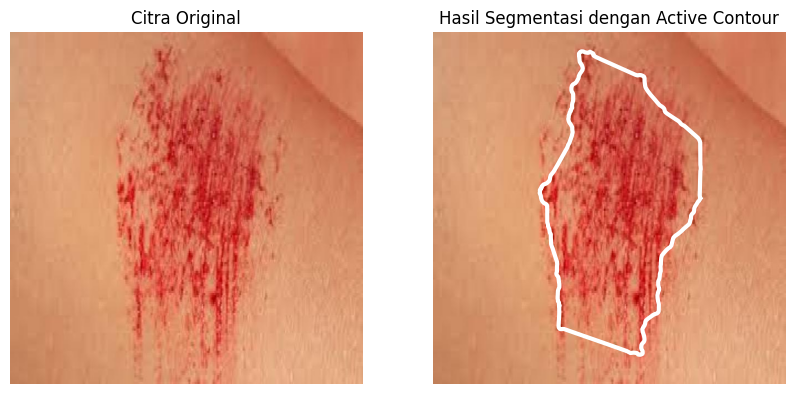

MSE:  104.5105419921875
PSNR:  13.969601304347288
Jenis Luka:  Large Abrasion


In [22]:
seg_active_contour(folder='abrasions', nomor=3, bright=144, x=300, a=300, y=320, b=300)

#### 2. Citra bruises(2).jpg

In [ ]:
seg_active_contour(folder='bruises', nomor=2, bright=75, x=300, a=300, y=320, b=300)

#### 3. Citra burns(36).jpg

In [ ]:
seg_active_contour(folder='burns', nomor=36, bright=215, x=300, a=300, y=320, b=300)

#### 4. Citra cut(15).jpg

In [ ]:
seg_active_contour(folder='cut', nomor=15, bright=200, x=300, a=300, y=320, b=300)

#### 5. Citra laceration(15).jpg

In [ ]:
seg_active_contour(folder='laceration', nomor=15, bright=120, x=300, a=300, y=320, b=300)

#### 6. Citra ingrown_nail(4).jpg

In [ ]:
seg_active_contour(folder='ingrown_nails', nomor=4, bright=146, x=320, a=150, y=360, b=150)

#### 7. Citra stab_wound(5).jpg

In [ ]:
seg_active_contour(folder='stab_wound', nomor=5, bright=180, x=250, a=200, y=250, b=200)

#### 8. Citra abrasions(1).jpg

In [ ]:
seg_active_contour(folder='abrasions', nomor=1, bright=140, x=300, a=200, y=320, b=130)

#### 9. Citra bruises(1).jpg

In [ ]:
seg_active_contour(folder='bruises', nomor=1, bright=80, x=300, a=200, y=430, b=130)

#### 10. Citra burns(24).jpg

In [ ]:
seg_active_contour(folder='burns', nomor=24, bright=160, x=350, a=220, y=300, b=300)

#### 11. Citra abrasions(19).jpg

In [ ]:
seg_active_contour(folder='abrasions', nomor=19, bright=150, x=400, a=200, y=320, b=130)

#### 12. Citra bruises(9).jpg

In [ ]:
seg_active_contour(folder='bruises', nomor=9, bright=100, x=350, a=450, y=320, b=450)

#### 13. Citra burns(22).jpg

In [ ]:
seg_active_contour(folder='burns', nomor=22, bright=120, x=280, a=100, y=350, b=100)

#### 14. Citra cut(1).jpg

In [ ]:
seg_active_contour(folder='cut', nomor=1, bright=180, x=300, a=300, y=320, b=300)

#### 15. Citra laceration(2).jpg

In [ ]:
seg_active_contour(folder='laceration', nomor=2, bright=215, x=300, a=150, y=320, b=150)

#### 16. Citra ingrown_nail(26).jpg

In [ ]:
seg_active_contour(folder='ingrown_nails', nomor=26, bright=160, x=340, a=150, y=300, b=150)

#### 17. Citra stab_wound(8).jpg

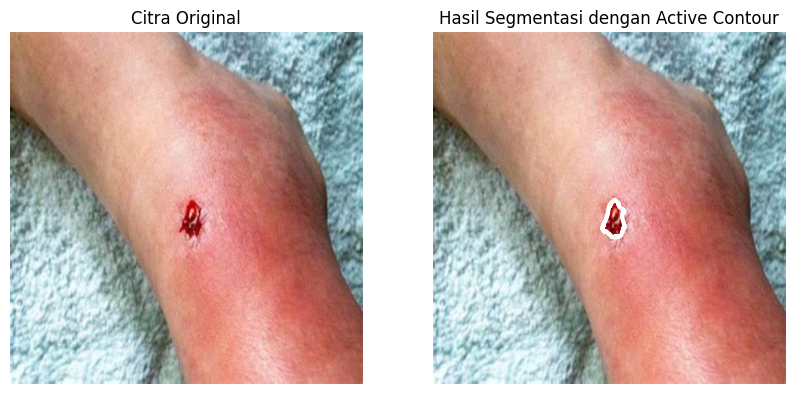

MSE:  101.97803466796876
PSNR:  14.02286861463692


In [19]:
seg_active_contour(folder='stab_wound', nomor=8, bright=180, x=300, a=200, y=300, b=200)

#### 18. Citra cut(2).jpg

In [ ]:
seg_active_contour(folder='cut', nomor=2, bright=200, x=300, a=250, y=320, b=250)

#### 19. Citra laceration(10).jpg

In [ ]:
seg_active_contour(folder='laceration', nomor=10, bright=140, x=300, a=200, y=400, b=100)

#### 20. Citra ingrown_nail(28).jpg

In [ ]:
seg_active_contour(folder='ingrown_nails', nomor=28, bright=157, x=150, a=150, y=430, b=150)

#### 21. Citra abrasions(17).jpg

In [ ]:
seg_active_contour(folder='abrasions', nomor=17, bright=155, x=300, a=250, y=320, b=240)

#### 22. Citra bruises(18).jpg

In [ ]:
seg_active_contour(folder='bruises', nomor=18, bright=90, x=300, a=200, y=350, b=200)

#### 23. Citra burns(22).jpg

In [ ]:
seg_active_contour(folder='burns', nomor=22, bright=125, x=300, a=150, y=380, b=150)

#### 24. Citra cut(20).jpg

In [ ]:
seg_active_contour(folder='cut', nomor=20, bright=126, x=300, a=400, y=290, b=200)

#### 25. Citra laceration(14).jpg

In [ ]:
seg_active_contour(folder='laceration', nomor=14, bright=180, x=300, a=200, y=300, b=200)

#### 26. Citra ingrown_nail(16).jpg

In [ ]:
seg_active_contour(folder='ingrown_nails', nomor=16, bright=144, x=360, a=120, y=140, b=120)

#### 27. Citra stab_wound(20).jpg

In [ ]:
seg_active_contour(folder='stab_wound', nomor=20, bright=215, x=300, a=200, y=250, b=200)

#### 28. Citra stab_wound(23).jpg

In [ ]:
seg_active_contour(folder='stab_wound', nomor=23, bright=190, x=300, a=200, y=350, b=200)

#### 29. Citra cut(26).jpg

In [ ]:
seg_active_contour(folder='cut', nomor=26, bright=100, x=300, a=200, y=300, b=200)

#### 30. Citra laceration(20).jpg

In [ ]:
seg_active_contour(folder='laceration', nomor=20, bright=185, x=300, a=200, y=280, b=200)

### Fungsi Metode Contour Detection

In [ ]:
def seg_contour_detection(folder, nomor, threshold):
    img = cv.imread(pick(folder, nomor))
    img_grayscale = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(img_grayscale, threshold, 255, cv.THRESH_BINARY)
    contours, hierarchy = cv.findContours(image=thresh, mode=cv.RETR_TREE, method=cv.CHAIN_APPROX_NONE)
    image_copy = img.copy()
    cv.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv.LINE_AA)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img[..., ::-1], cmap='gray')
    axes[0].set_title("Citra Original")
    axes[0].axis('off')
    axes[1].imshow(image_copy[..., ::-1], cmap='gray')
    axes[1].set_title("Hasil Segmentasi dengan Contour Detection")
    axes[1].axis('off')
    plt.show()
    selisih = np.array(image_copy) - np.array(img)
    mse = np.mean(np.square(selisih))
    psnr = 10 * np.log10(255 / np.sqrt(mse))
    print("MSE: ", mse)
    print("PSNR: ", psnr)

#### 1. Citra abrasion(3).jpg

In [ ]:
seg_contour_detection(folder='abrasions', nomor=3, threshold=110)

#### 2. Citra bruises(2).jpg

In [ ]:
seg_contour_detection(folder='bruises', nomor=2, threshold=180)

#### 3. Citra burns(36).jpg

In [ ]:
seg_contour_detection(folder='burns', nomor=36, threshold=50)

#### 4. Citra cut(15).jpg

In [ ]:
seg_contour_detection(folder='cut', nomor=15, threshold=25)

#### 5. Citra laceration(15).jpg

In [ ]:
seg_contour_detection(folder='laceration', nomor=15, threshold=130)

#### 6. Citra ingrown_nail(4).jpg

In [ ]:
seg_contour_detection(folder='ingrown_nails', nomor=4, threshold=82)

#### 7. Citra stab_wound(5).jpg

In [ ]:
seg_contour_detection(folder='stab_wound', nomor=5, threshold=70)

#### 8. Citra abrasions(1).jpg

In [ ]:
seg_contour_detection(folder='abrasions', nomor=1, threshold=110)

#### 9. Citra bruises(1).jpg

In [ ]:
seg_contour_detection(folder='bruises', nomor=1, threshold=140)

#### 10. Citra burns(24).jpg

In [ ]:
seg_contour_detection(folder='burns', nomor=24, threshold=35)

#### 11. Citra abrasions(19).jpg

In [ ]:
seg_contour_detection(folder='abrasions', nomor=19, threshold=124)

#### 12. Citra bruises(9).jpg

In [ ]:
seg_contour_detection(folder='bruises', nomor=9, threshold=144)

#### 13. Citra burns(22).jpg

In [ ]:
seg_contour_detection(folder='burns', nomor=22, threshold=128)

#### 14. Citra cut(1).jpg

In [ ]:
seg_contour_detection(folder='cut', nomor=1, threshold=76)

#### 15. Citra laceration(2).jpg

In [ ]:
seg_contour_detection(folder='laceration', nomor=2, threshold=31)

#### 16. Citra ingrown_nail(26).jpg

In [ ]:
seg_contour_detection(folder='ingrown_nails', nomor=26, threshold=93)

#### 17. Citra stab_wound(8).jpg

In [ ]:
seg_contour_detection(folder='stab_wound', nomor=8, threshold=55)

#### 18. Citra cut(2).jpg

In [ ]:
seg_contour_detection(folder='cut', nomor=2, threshold=75)

#### 19. Citra laceration(10).jpg

In [ ]:
seg_contour_detection(folder='laceration', nomor=10, threshold=125)

#### 20. Citra ingrown_nail(28).jpg

In [ ]:
seg_contour_detection(folder='ingrown_nails', nomor=28, threshold=95)

#### 21. Citra abrasions(17).jpg

In [ ]:
seg_contour_detection(folder='abrasions', nomor=17, threshold=126)

#### 22. Citra bruises(18).jpg

In [ ]:
seg_contour_detection(folder='bruises', nomor=18, threshold=160)

#### 23. Citra burns(22).jpg

In [ ]:
seg_contour_detection(folder='burns', nomor=22, threshold=131)

#### 24. Citra cut(9).jpg

In [ ]:
seg_contour_detection(folder='cut', nomor=20, threshold=125)

#### 25. Citra laceration(14).jpg

In [ ]:
seg_contour_detection(folder='laceration', nomor=14, threshold=80)

#### 26. Citra ingrown_nail(16).jpg

In [ ]:
seg_contour_detection(folder='ingrown_nails', nomor=16, threshold=80)

#### 27. Citra stab_wound(20).jpg

In [ ]:
seg_contour_detection(folder='stab_wound', nomor=20, threshold=25)

#### 28. Citra stab_wound(23).jpg

In [ ]:
seg_contour_detection(folder='stab_wound', nomor=23, threshold=23)

#### 29. Citra cut().jpg

In [ ]:
seg_contour_detection(folder='cut', nomor=26, threshold=140)

#### 30. Citra laceration(20).jpg

In [ ]:
seg_contour_detection(folder='laceration', nomor=20, threshold=68)

### Pengujian Waktu Eksekusi

In [ ]:
def metode_active_contour(folder, nomor):
    citra = cv.imread(pick(folder, nomor))
    citra_grayscale = cv.cvtColor(citra, cv.COLOR_BGR2GRAY)
    brightness = 200
    citra_brightened = cv.add(citra_grayscale, brightness)
    citra_denoise = cv.medianBlur(citra_brightened, 3)
    citra_denoise = cv.fastNlMeansDenoising(citra_denoise, None, 10, 10, 7)
    citra_contrast_adjusted = cv.equalizeHist(citra_denoise)
    s = np.linspace(0, 2*np.pi, 500)
    r = 300 + 300*np.sin(s)
    c = 320 + 300*np.cos(s)
    init = np.array([r, c]).T
    snake = active_contour(gaussian(citra_contrast_adjusted, 3, preserve_range=False),
                           init, alpha=0.01, beta=0, gamma=0.001)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].set_title("Citra Original")
    axes[0].imshow(citra[..., ::-1], cmap='gray')
    axes[0].axis('off')
    axes[1].imshow(citra[..., ::-1], cmap='gray')
    axes[1].plot(snake[:, 1], snake[:, 0], '-w', lw=3)
    axes[1].set_title("Hasil Segmentasi dengan Active Contour")
    axes[1].axis('off')
    plt.show()
    selisih = np.array(citra_denoise) - np.array(citra[:, :, 0])
    mse = np.mean(np.square(selisih))
    psnr = 10 * np.log10(255 / np.sqrt(mse))
    print("MSE: ", mse)
    print("PSNR: ", psnr)

def metode_contour_detection(folder, nomor):
    img = cv.imread(pick(folder, nomor))
    img_grayscale = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(img_grayscale, 25, 255, cv.THRESH_BINARY)
    contours, hierarchy = cv.findContours(image=thresh, mode=cv.RETR_TREE, method=cv.CHAIN_APPROX_NONE)
    image_copy = img.copy()
    cv.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv.LINE_AA)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img[..., ::-1], cmap='gray')
    axes[0].set_title("Citra Original")
    axes[0].axis('off')
    axes[1].imshow(image_copy[..., ::-1], cmap='gray')
    axes[1].set_title("Hasil Segmentasi dengan Contour Detection")
    axes[1].axis('off')
    plt.show()
    selisih = np.array(image_copy) - np.array(img)
    mse = np.mean(np.square(selisih))
    psnr = 10 * np.log10(255 / np.sqrt(mse))
    print("MSE: ", mse)
    print("PSNR: ", psnr)

In [ ]:
# Folder dan nomor citra
folder = 'cut'
nomor = 15

# Menginisialisasi list untuk menyimpan hasil eksekusi dan akurasi
execution_times_active_contour = []
execution_times_contour_detection = []

# Melakukan iterasi 30 kali
for _ in range(30):
    start_time = time.time()
    metode_active_contour(folder, nomor)
    execution_time = time.time() - start_time
    execution_times_active_contour.append(execution_time)

    start_time = time.time()
    metode_contour_detection(folder, nomor)
    execution_time = time.time() - start_time
    execution_times_contour_detection.append(execution_time)

# Menghitung rata-rata eksekusi
avg_execution_time_active_contour = np.mean(execution_times_active_contour)
avg_execution_time_contour_detection = np.mean(execution_times_contour_detection)

# Menampilkan perbandingan rata-rata eksekusi
print("Rata-rata Waktu Eksekusi Active Contour:", avg_execution_time_active_contour, "detik")
print("Rata-rata Waktu Eksekusi Contour Detection:", avg_execution_time_contour_detection, "detik")

# Menggabungkan list execution_times_active_contour dan execution_times_contour_detection menjadi array 2D
data = np.array([execution_times_active_contour, execution_times_contour_detection]).T

# Membuat DataFrame dari array dan menampilkan tabel
pd.DataFrame(data, columns=['Active Contour', 'Contour Detection'])